In [28]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.tri as mtri
import matplotlib.tri as tri

import json
import os

from networks.DeepONet2DGeometry_upgraded import DeepONet
import UDON
import UDON.workspace as ws

# final : INFO:root:epoch 2000: loss 0.010762, time 3.75 sec, lr 0.000031

#INFO:root:epoch 670: loss 0.015846, time 5.96 sec, lr 0.000250
#INFO:root:epoch 670: test loss: 0.148396

#INFO:root:epoch 2000: loss 0.006819, time 5.91 sec, lr 0.000031
#INFO:root:epoch 2000: test loss: 0.151128

In [29]:
specs = json.load(open("experiments/unit_squares_1_3_holes/specs.json"))

ws.specs = specs
ws.split = "train"
ws.deeponet_model = "500"
ws.deepsdf_model = "latest"

model_path = os.path.join("experiments", specs["experiment_name"], ws.deep_o_net_folder, ws.parameters_folder, f"{ws.deeponet_model}.pth")

deeponet = DeepONet(**specs["DeepONet"]["NetworkSpecs"])
deeponet.load_state_dict(torch.load(model_path)["model_state_dict"])
deeponet.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
deeponet.to(device)

C:\Users\maxim\AppData\Local\Temp\ipykernel_66904\1623420861.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  deeponet.load_state_dict(torch.load(model_path)["model_stat

DeepONet(
  (branch_net): Sequential(
    (0): Linear(in_features=1, out_features=128, bias=True)
    (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (8): ReLU()
    (9): Linear(in_features=128, out_features=128, bias=True)
    (10): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (11): ReLU()
    (12): Linear(in_features=128, out_features=128, bias=True)
    (13): ReLU()
  )
  (trunk_net): Sequential(
    (0): Linear(in_features=34, out_features=128, bias=True)
    (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=94, bias=True)
    (4): LayerNorm((94,), eps=1e-05, elementwise_affine=True)
    (5): ReLU()
    (6):

In [30]:
train_split_file = specs["PDETrainSplit"]
with open(train_split_file, "r") as f:
    train_split = json.load(f)

In [31]:
print("Device: ", next(deeponet.parameters()).device)

Device:  cuda:0


In [32]:
pde_samples = UDON.data.PDESamples(specs["DataSource"], train_split, None, False)

In [33]:
def get_sol(pde_sample, idx):
    sol = pde_sample[idx][0][:, -1]
    return sol

def get_rhs(pde_sample, idx):
    coords = pde_sample[idx][0][:, -2]
    return coords

def get_trunk_inputs(pde_sample, idx):
    trunk_inputs = pde_sample[idx][0][:, :-2]
    return trunk_inputs

def get_coords(pde_samples, idx):
    coords = get_trunk_inputs(pde_samples, idx)[:, -2:]
    return coords

def get_lat_vec(pde_samples, idx):
    trunk_inputs = get_trunk_inputs(pde_samples, idx)
    lat_vec = trunk_inputs[:, :-2]
    return lat_vec

def get_preds(pde_samples, idx):
    pde_rhs = get_rhs(pde_samples, idx).unsqueeze(1).cuda()
    pde_trunk_inputs = get_trunk_inputs(pde_samples, idx).cuda()
    pde_data = get_coords(pde_samples, idx).cuda()
    pde_gt = get_sol(pde_samples, idx).unsqueeze(1).cuda()

    deeponet_out = deeponet(pde_rhs, pde_trunk_inputs)

    return deeponet_out, pde_gt, pde_data

In [34]:
preds, gt, coords = get_preds(pde_samples, 45)

In [35]:
preds.shape, gt.shape, coords.shape

(torch.Size([555, 1]), torch.Size([555, 1]), torch.Size([555, 2]))

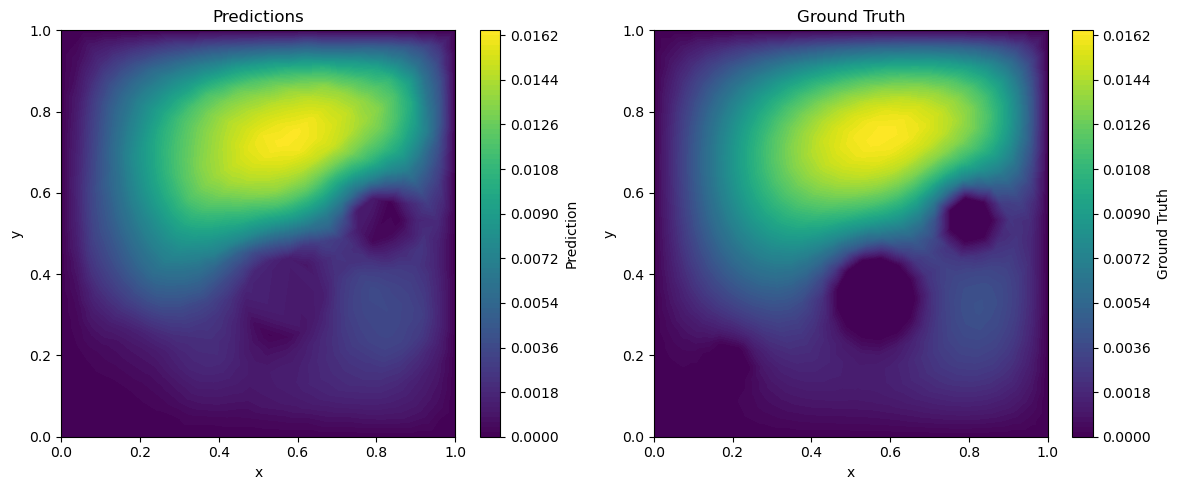

In [36]:
# Convert tensors to numpy arrays and flatten values
coords_np = coords.detach().cpu().numpy()
preds_np = preds.detach().cpu().numpy().flatten()
gt_np = gt.detach().cpu().numpy().flatten()

# Create a triangulation from the coordinates
triang = tri.Triangulation(coords_np[:, 0], coords_np[:, 1])

# Compute common color scale limits
vmin = min(preds_np.min(), gt_np.min())
vmax = max(preds_np.max(), gt_np.max())

# Plot predictions
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
contour1 = plt.tricontourf(triang, preds_np, levels=100, cmap='viridis', vmin=vmin, vmax=vmax)
plt.colorbar(contour1, label='Prediction')
plt.title("Predictions")
plt.xlabel("x")
plt.ylabel("y")

# Plot ground truth
plt.subplot(1, 2, 2)
contour2 = plt.tricontourf(triang, gt_np, levels=100, cmap='viridis', vmin=vmin, vmax=vmax)
plt.colorbar(contour2, label='Ground Truth')
plt.title("Ground Truth")
plt.xlabel("x")
plt.ylabel("y")

plt.tight_layout()
plt.show()

Text(0, 0.5, 'y')

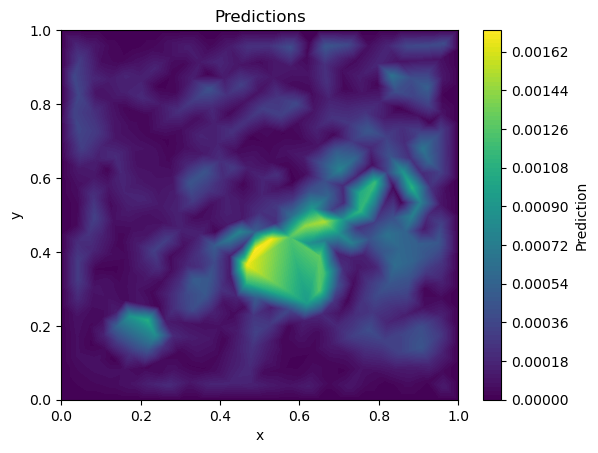

In [37]:
#plt.subplot(1, 2, 1)
contour1 = plt.tricontourf(triang, abs(preds_np - gt_np), levels=100, cmap='viridis')#, vmin=vmin, vmax=vmax)
plt.colorbar(contour1, label='Prediction')
plt.title("Predictions")
plt.xlabel("x")
plt.ylabel("y")

In [38]:
pde_samples.npyfiles

['unit_squares_with_holes\\PDEData\\square_with_holes_2_0.281_0.726\\coeff_0.4837.npz',
 'unit_squares_with_holes\\PDEData\\square_with_holes_2_0.281_0.726\\coeff_0.4988.npz',
 'unit_squares_with_holes\\PDEData\\square_with_holes_2_0.281_0.726\\coeff_0.7694.npz',
 'unit_squares_with_holes\\PDEData\\square_with_holes_2_0.281_0.726\\coeff_0.9711.npz',
 'unit_squares_with_holes\\PDEData\\square_with_holes_2_0.281_0.726\\coeff_1.3573.npz',
 'unit_squares_with_holes\\PDEData\\square_with_holes_2_0.281_0.726\\coeff_1.7270.npz',
 'unit_squares_with_holes\\PDEData\\square_with_holes_2_0.281_0.726\\coeff_1.7287.npz',
 'unit_squares_with_holes\\PDEData\\square_with_holes_2_0.281_0.726\\coeff_1.9243.npz',
 'unit_squares_with_holes\\PDEData\\square_with_holes_2_0.281_0.726\\coeff_1.9254.npz',
 'unit_squares_with_holes\\PDEData\\square_with_holes_2_0.281_0.726\\coeff_1.9875.npz',
 'unit_squares_with_holes\\PDEData\\square_with_holes_3_0.119_0.519_0.796\\coeff_0.3259.npz',
 'unit_squares_with_holes\

In [39]:
pde_samples.npyfiles.index('unit_squares_with_holes\\PDEData\\square_with_holes_1_0.555\\coeff_0.2838.npz')

960

In [40]:
pde_samples.npyfiles.index('unit_squares_with_holes\\PDEData\\square_with_holes_2_0.281_0.726\\coeff_0.4988.npz')

1

In [41]:
pde_samples.npyfiles.index('unit_squares_with_holes\\PDEData\\square_with_holes_3_0.119_0.519_0.796\\coeff_1.2695.npz')

16

# Test shapes

In [42]:
train_split_file = specs["PDETestSplit"]
with open(train_split_file, "r") as f:
    train_split = json.load(f)

ws.specs = specs
ws.split = "test"
ws.deeponet_model = "500"
ws.deepsdf_model = "latest"

model_path = os.path.join("experiments", specs["experiment_name"], ws.deep_o_net_folder, ws.parameters_folder, f"{ws.deeponet_model}.pth")

deeponet = DeepONet(**specs["DeepONet"]["NetworkSpecs"])
deeponet.load_state_dict(torch.load(model_path)["model_state_dict"])
deeponet.eval()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
deeponet.to(device)

pde_samples = UDON.data.PDESamples(specs["DataSource"], train_split, None, False)


C:\Users\maxim\AppData\Local\Temp\ipykernel_66904\509834321.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  deeponet.load_state_dict(torch.load(model_path)["model_state

In [43]:
preds, gt, coords = get_preds(pde_samples, 110)

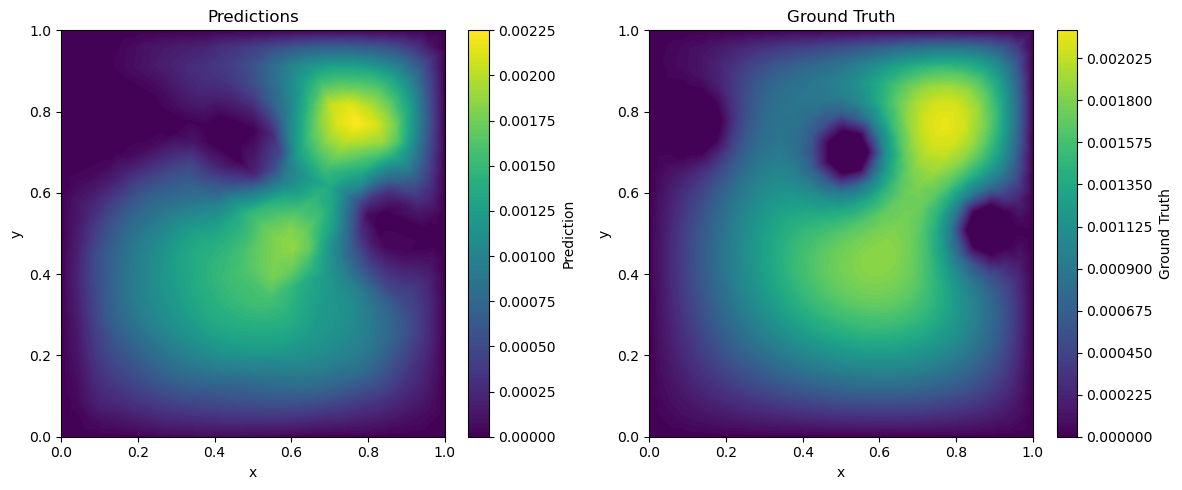

In [44]:
# Convert tensors to numpy arrays and flatten values
coords_np = coords.detach().cpu().numpy()
preds_np = preds.detach().cpu().numpy().flatten()
gt_np = gt.detach().cpu().numpy().flatten()

# Create a triangulation from the coordinates
triang = tri.Triangulation(coords_np[:, 0], coords_np[:, 1])

# Compute common color scale limits
vmin = min(preds_np.min(), gt_np.min())
vmax = max(preds_np.max(), gt_np.max())

# Plot predictions
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
contour1 = plt.tricontourf(triang, preds_np, levels=100, cmap='viridis', vmin=vmin, vmax=vmax)
plt.colorbar(contour1, label='Prediction')
plt.title("Predictions")
plt.xlabel("x")
plt.ylabel("y")

# Plot ground truth
plt.subplot(1, 2, 2)
contour2 = plt.tricontourf(triang, gt_np, levels=100, cmap='viridis', vmin=vmin, vmax=vmax)
plt.colorbar(contour2, label='Ground Truth')
plt.title("Ground Truth")
plt.xlabel("x")
plt.ylabel("y")

plt.tight_layout()
plt.show()

Text(0, 0.5, 'y')

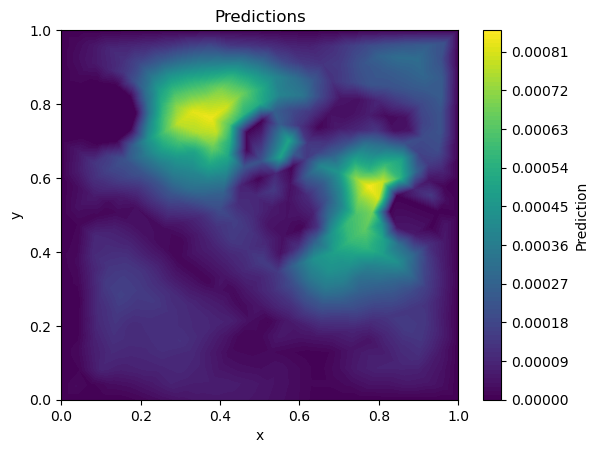

In [45]:
#plt.subplot(1, 2, 1)
contour1 = plt.tricontourf(triang, abs(preds_np - gt_np), levels=100, cmap='viridis')#, vmin=vmin, vmax=vmax)
plt.colorbar(contour1, label='Prediction')
plt.title("Predictions")
plt.xlabel("x")
plt.ylabel("y")

# Random test

In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class DeepONet(nn.Module):
    """
    DeepONet for 2D geometry problems.
    
    Args:
        num_branch_inputs (int): Number of inputs for the branch network.
        num_basis_functions (int): Number of basis functions for the trunk network.
        num_trunk_outputs (int): Number of outputs for the trunk network.
        num_hidden_layers (int): Number of hidden layers in the networks.
        hidden_dim (int): Dimension of the hidden layers.
    """
    
    def __init__(
        self, 
        num_branch_inputs:int,
        num_basis_functions:int, 
        num_trunk_inputs:int, 
        branch_dims:list, 
        trunk_dims:list, 
        dropout:list=None, 
        dropout_prob:float=0.0, 
        norm_layers:tuple=(), 
        latent_in:tuple=(),
        weight_norm:bool=False):

        super(DeepONet, self).__init__()

        self.num_basis_functions = num_basis_functions
        self.num_branch_inputs = num_branch_inputs
        self.num_trunk_inputs = num_trunk_inputs
        self.branch_dims = branch_dims
        self.trunk_dims = trunk_dims

        self.branch_norm_layers, self.trunk_norm_layers = norm_layers
        self.latent_in = latent_in

        branch_dims = [num_branch_inputs] + branch_dims + [num_basis_functions]
        trunk_dims = [num_trunk_inputs] + trunk_dims + [num_basis_functions]

        self.num_branch_layers = len(branch_dims) - 1
        self.num_trunk_layers = len(trunk_dims) - 1

        # Branch network 
        branch_layers = []

        for layer in range(self.num_branch_layers):

            out_dim = branch_dims[layer + 1]
            """
            if layer != self.num_branch_layers - 1:
                out_dim -= num_basis_functions
            """
            if weight_norm and layer in self.branch_norm_layers:
                branch_layers.append(nn.utils.weight_norm(nn.Linear(branch_dims[layer], out_dim)))
            else:
                branch_layers.append(nn.Linear(branch_dims[layer], out_dim))

            if layer in self.branch_norm_layers:
                branch_layers.append(nn.LayerNorm(out_dim))
            branch_layers.append(nn.ReLU())

        self.branch_net = nn.Sequential(*branch_layers)

        # Trunk network
        trunk_layers = []
        for layer in range(self.num_trunk_layers):
            if layer + 1 in self.latent_in:
                out_dim = trunk_dims[layer + 1] - trunk_dims[0]
            else:
                out_dim = trunk_dims[layer + 1]
                """
                if layer != self.num_trunk_layers - 1:
                    out_dim -= num_basis_functions
                """
            if weight_norm and layer in self.trunk_norm_layers:
                trunk_layers.append(nn.utils.weight_norm(nn.Linear(trunk_dims[layer], out_dim)))
            else:
                trunk_layers.append(nn.Linear(trunk_dims[layer], out_dim))

            if layer in self.trunk_norm_layers:
                trunk_layers.append(nn.LayerNorm(out_dim))
            trunk_layers.append(nn.ReLU())

        self.trunk_net = nn.Sequential(*trunk_layers)

    def forward(self, branch_input, trunk_input):
        """
        Forward pass for the DeepONet.

        Args:
            branch_input (torch.Tensor): Input tensor for the branch network.
            trunk_input (torch.Tensor): Input tensor for the trunk network.

        Returns:
            torch.Tensor: Output of the DeepONet.
        """
        # Pass through branch network
        branch_output = self.branch_net(branch_input)
        #print("Branch output shape:", branch_output.shape)
        # Pass through trunk network
        trunk_output = self.trunk_net(trunk_input)
        #print("Trunk output shape:", trunk_output.shape)

        out = torch.sum(branch_output * trunk_output, -1) / math.sqrt(self.num_basis_functions) # peut être ajouter ,1 dans la somme pour que la somme se fasse sur les colonnes
        out = out.unsqueeze(1)

        return out


In [47]:
deeponet = DeepONet(**specs["DeepONet"]["NetworkSpecs"])

In [48]:
deeponet.branch_net[0](torch.tensor([5.0]))

tensor([ 0.4692,  3.0822,  0.5767,  2.1857, -3.3030,  3.4526, -4.2472,  1.7695,
        -0.4894,  5.4859, -0.4170, -1.2054, -1.6344,  2.1246, -4.3992,  0.7667,
        -4.1356,  1.4605, -1.7462, -2.4716, -2.5795, -1.7638, -1.2540, -0.5520,
        -1.5119,  0.7699, -3.5407, -0.2545, -2.0384,  5.4220, -2.5046, -3.2374,
         4.1741,  4.3269, -0.0272,  4.4590, -1.8341, -3.7436,  2.8393, -3.3811,
        -2.6061,  3.3403,  1.5742,  3.1695,  4.3619,  5.7370, -0.1200,  2.5617,
         3.8476,  1.5150,  3.6250,  3.8220,  4.1251,  2.2590,  0.1778,  3.0800,
        -4.1889,  2.9448, -4.6619, -3.6738, -0.8685, -1.3169,  3.0091, -2.1218,
         2.2901,  5.4303,  3.3597, -3.4199,  3.7645,  2.2345,  5.7851, -4.9800,
         0.3915,  1.1495,  3.1622, -0.0883,  0.9851,  1.9072, -3.8073, -3.3212,
         1.0179, -1.2104,  2.7257, -3.2293, -5.2753, -1.4763,  4.6417,  0.4885,
        -3.4555,  4.2898,  0.7765, -1.2018,  3.4500,  3.8193,  4.8226, -2.0494,
        -2.4484,  2.1066,  0.1951, -3.35

In [49]:
len(deeponet.branch_net)

14

In [50]:
[i for i, layer in enumerate(deeponet.branch_net) if isinstance(layer, nn.Linear)]

[0, 3, 6, 9, 12]

In [51]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class DeepONet(nn.Module):
    """
    DeepONet for 2D geometry problems.
    
    Args:
        num_branch_inputs (int): Number of inputs for the branch network.
        num_basis_functions (int): Number of basis functions for the trunk network.
        num_trunk_outputs (int): Number of outputs for the trunk network.
        num_hidden_layers (int): Number of hidden layers in the networks.
        hidden_dim (int): Dimension of the hidden layers.
    """
    
    def __init__(
        self, 
        num_branch_inputs:int,
        num_basis_functions:int, 
        num_trunk_inputs:int, 
        branch_dims:list, 
        trunk_dims:list, 
        dropout:list=None, 
        dropout_prob:float=0.0, 
        norm_layers:tuple=(), 
        latent_in:tuple=(),
        weight_norm:bool=False):

        super(DeepONet, self).__init__()

        self.num_basis_functions = num_basis_functions
        self.num_branch_inputs = num_branch_inputs
        self.num_trunk_inputs = num_trunk_inputs
        self.branch_dims = branch_dims
        self.trunk_dims = trunk_dims

        self.branch_norm_layers, self.trunk_norm_layers = norm_layers
        self.latent_in = latent_in

        branch_dims = [num_branch_inputs] + branch_dims + [num_basis_functions]
        trunk_dims = [num_trunk_inputs] + trunk_dims + [num_basis_functions]

        self.num_branch_layers = len(branch_dims) - 1
        self.num_trunk_layers = len(trunk_dims) - 1

        if dropout != ():
            if len(dropout) != 2:
                raise ValueError("Dropout must be a tuple of two lists: (branch_dropout, trunk_dropout)")
            self.branch_dropout, self.trunk_dropout = dropout

        # Branch network 
        branch_layers = []

        for layer in range(self.num_branch_layers):

            out_dim = branch_dims[layer + 1]
            """
            if layer != self.num_branch_layers - 1:
                out_dim -= num_basis_functions
            """
            if layer in self.branch_dropout:
                branch_layers.append(nn.Dropout(dropout_prob))

            if weight_norm and layer in self.branch_norm_layers:
                branch_layers.append(nn.utils.weight_norm(nn.Linear(branch_dims[layer], out_dim)))
            else:
                branch_layers.append(nn.Linear(branch_dims[layer], out_dim))

            if layer in self.branch_norm_layers:
                branch_layers.append(nn.LayerNorm(out_dim))
            branch_layers.append(nn.ReLU())

        self.branch_net = nn.Sequential(*branch_layers)

        # Trunk network
        trunk_layers = []

        for layer in range(self.num_trunk_layers):
            if layer in self.trunk_dropout:
                trunk_layers.append(nn.Dropout(dropout_prob))
            if layer + 1 in self.latent_in:
                out_dim = trunk_dims[layer + 1] - trunk_dims[0]
            else:
                out_dim = trunk_dims[layer + 1]
                """
                if layer != self.num_trunk_layers - 1:
                    out_dim -= num_basis_functions
                """
            if weight_norm and layer in self.trunk_norm_layers:
                trunk_layers.append(nn.utils.weight_norm(nn.Linear(trunk_dims[layer], out_dim)))
            else:
                trunk_layers.append(nn.Linear(trunk_dims[layer], out_dim))

            if layer in self.trunk_norm_layers:
                trunk_layers.append(nn.LayerNorm(out_dim))
            trunk_layers.append(nn.ReLU())

        self.trunk_net = nn.Sequential(*trunk_layers)
        self.trunk_lin_idx = [i for i, layer in enumerate(self.trunk_net) if isinstance(layer, nn.Linear)]
        self.latent_in = [self.trunk_lin_idx[i] for i in self.latent_in]

    def forward(self, branch_input, trunk_input):
        """
        Forward pass for the DeepONet.

        Args:
            branch_input (torch.Tensor): Input tensor for the branch network.
            trunk_input (torch.Tensor): Input tensor for the trunk network.

        Returns:
            torch.Tensor: Output of the DeepONet.
        """
        original_trunk_input = trunk_input.clone()

        # Pass through branch network
        branch_output = self.branch_net(branch_input)
        #print("Branch output shape:", branch_output.shape)
        # Pass through trunk network
        for layer in range(len(self.trunk_net)):
            if layer in self.latent_in:
                trunk_input = self.trunk_net[layer](torch.cat((trunk_input, original_trunk_input), dim=1))
            else:
                trunk_input = self.trunk_net[layer](trunk_input)

            

        #trunk_output = self.trunk_net(trunk_input)
        #print("Trunk output shape:", trunk_output.shape)

        out = torch.sum(branch_output * trunk_input, -1) / math.sqrt(self.num_basis_functions) # peut être ajouter ,1 dans la somme pour que la somme se fasse sur les colonnes
        out = out.unsqueeze(1)

        return out


In [52]:
deeponet = DeepONet(**specs["DeepONet"]["NetworkSpecs"])

In [53]:
deeponet(torch.tensor([2.0]), torch.rand(1,34))

tensor([[0.3405]], grad_fn=<UnsqueezeBackward0>)

In [54]:
torch.cat((torch.rand(64,200,94), torch.rand(64,200,34)), dim=-1).shape

torch.Size([64, 200, 128])